In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
import datetime as dt
import time
from datetime import timedelta

## Reflect Tables into SQLALchemy ORM

In [3]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import inspect
from sqlalchemy import create_engine, func

In [4]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [5]:
# reflect an existing database into a new model
Base = automap_base()

# reflect the tables
Base.prepare(engine, reflect = True)

In [6]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [7]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [8]:
# Create our session (link) from Python to the DB
session = Session(engine)
inspector = inspect(engine)

## Bonus Challenge Assignment: Temperature Analysis II

In [9]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, maximum, and average temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# For example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [31]:
# Use the function `calc_temps` to calculate the tmin, tavg, and tmax for a year in the data set

start_date = "2016-12-05"
end_date = "2016-12-12"

temps = calc_temps(start_date, end_date)
print(temps)

[(65.0, 70.19607843137256, 78.0)]


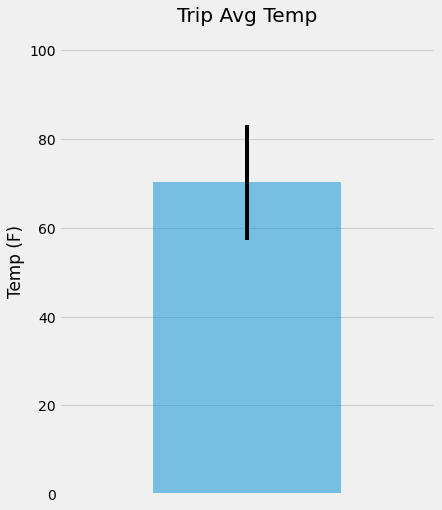

In [32]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for bar height (y value)
# Use the peak-to-peak (tmax-tmin) value as the y error bar (year)
tmin = temps[0][0]
tmax = temps[0][2]
tave = round(temps[0][1], 2)
error = (tmax - tmin)

calc_temp_df = pd.DataFrame(temps, columns=['Min Temp', 'Avg Temp', 'Max Temp'])

avg_temp = calc_temp_df['Avg Temp']
tmin_tmax_temp = calc_temp_df.iloc[0]['Max Temp'] - calc_temp_df.iloc[0]['Min Temp']
avg_temp.plot(kind = 'bar', yerr=error, figsize=(6,8), alpha=0.5)

plt.title("Trip Avg Temp")
plt.ylabel("Temp (F)")
plt.xticks([])
plt.ylim(0,105)
plt.grid(b=None, which='major', axis='x')

plt.savefig("Output/Trip Avg Temp.png")
plt.show()

### Daily Rainfall Average

In [33]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's 
# matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation
sel = [Station.station, Station.name, Station.latitude, Station.longitude, Station.elevation, func.sum(Measurement.prcp)]

rainfall_query = session.query(*sel).\
    filter(Station.station == Measurement.station).\
    filter(Measurement.date >= start_date).\
    filter(Measurement.date <= end_date).\
    group_by(Measurement.station).\
    order_by(func.sum(Measurement.prcp).desc()).all()

rainfall_df = pd.DataFrame(rainfall_query, columns=['Station', 'Name', 'Latitude', 'Longitude', 'Elevation', 'Prcp Amount'])

rainfall_df = rainfall_df.sort_values("Prcp Amount", ascending=False)
rainfall_df

,Station,Name,Latitude,Longitude,Elevation,Prcp Amount
0,USC00516128,"MANOA LYON ARBO 785.2, HI US",21.33310,-157.80250,152.4,2.25
1,USC00519397,"WAIKIKI 717.2, HI US",21.27160,-157.81680,3.0,1.10
2,USC00513117,"KANEOHE 838.1, HI US",21.42340,-157.80150,14.6,0.95
3,USC00519281,"WAIHEE 837.5, HI US",21.45167,-157.84889,32.9,0.74
4,USC00519523,"WAIMANALO EXPERIMENTAL FARM, HI US",21.33556,-157.71139,19.5,0.59
5,USC00514830,"KUALOA RANCH HEADQUARTERS 886.9, HI US",21.52130,-157.83740,7.0,0.48
6,USC00517948,"PEARL CITY, HI US",21.39340,-157.97510,11.9,0.29


In [34]:
# Use this function to calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()

# For example
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [35]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip
start_date = '2017-08-01'
end_date = '2017-08-07'

# Use the start and end date to create a range of dates
trip_duration = pd.date_range(start = start_date, end = end_date)

# Strip off the year and save a list of strings in the format %m-%d
month_list = []
trip_days = []

for date in trip_duration:
    month_list.append(dt.datetime.strftime(date, '%m-%d'))
    trip_days.append(dt.datetime.strftime(date, '%Y-%m-%d'))
    
# Use the `daily_normals` function to calculate the normals for each date string 
# and append the results to a list called `normals`.
normals = []
for month_day in month_list:
    normals.append(list(np.ravel(daily_normals(month_day))))

normals

[[67.0, 75.54, 83.0],
 [68.0, 75.60377358490567, 84.0],
 [70.0, 76.61111111111111, 85.0],
 [69.0, 76.71153846153847, 84.0],
 [69.0, 76.14814814814815, 82.0],
 [67.0, 76.25, 83.0],
 [71.0, 77.15686274509804, 83.0]]

In [38]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index
normals_df = pd.DataFrame(normals, columns=['T Min', 'T Avg', 'T Max'])
normals_df.index.name = "Vacation Date"
normals_df

,T Min,T Avg,T Max
Vacation Date,,,
0,67.0,75.540000,83.0
1,68.0,75.603774,84.0
2,70.0,76.611111,85.0
3,69.0,76.711538,84.0
4,69.0,76.148148,82.0
5,67.0,76.250000,83.0
6,71.0,77.156863,83.0


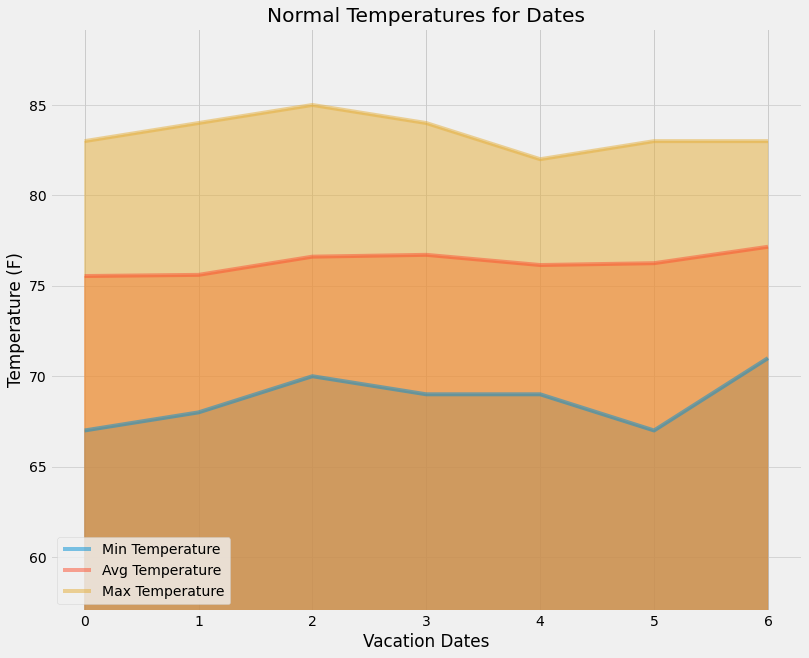

In [39]:
# Plot the daily normals as an area plot with `stacked=False`
normals_df.plot.area(stacked=False, figsize=(12,10))

plt.legend(('Min Temperature', 'Avg Temperature', 'Max Temperature'),loc='lower left')

plt.grid(axis='y', alpha=0.75)
plt.xlabel('Vacation Dates')
plt.ylabel('Temperature (F)')
plt.xticks
plt.yticks
plt.title('Normal Temperatures for Dates')
plt.ylim(bottom=min(normals_df['T Min'])-10)

plt.savefig("Output/Norm Temp for Dates.png")
plt.show()

## Close Session

In [40]:
# Close Session
session.close()